In [1]:
from quchem.Simulating_Quantum_Circuit import *
from quchem.Ansatz_Generator_Functions import *
from openfermion.ops import QubitOperator
HF_circ = [cirq.X.on(cirq.LineQubit(0)), cirq.X.on(cirq.LineQubit(1))]
x = QubitOperator('X0 Y1 Z2 Y3', 0.25j)
theta = np.pi
full_exp_circ_obj = full_exponentiated_PauliWord_circuit(x, theta)
UCCSD_circ = cirq.Circuit(cirq.decompose_once((full_exp_circ_obj(*cirq.LineQubit.range(full_exp_circ_obj.num_qubits())))))
YY = QubitOperator('X0 X1 Y3', 0.25j)
pauliword_change_and_measure_obj = change_pauliword_to_Z_basis_then_measure(YY)
P_measure = cirq.Circuit(cirq.decompose_once((pauliword_change_and_measure_obj(*cirq.LineQubit.range(pauliword_change_and_measure_obj.num_qubits())))))

full_circuit = cirq.Circuit([*HF_circ, *UCCSD_circ.all_operations(), *P_measure.all_operations()])
print(full_circuit)

0: ───X──────────H──────────@───────────────────────────────────────@──────────H───────────Ry(-0.5π)───M───
                            │                                       │                                  │
1: ───X──────────Rx(0.5π)───X───@───────────────────────@───────────X──────────Rx(-0.5π)───Ry(-0.5π)───M───
                                │                       │                                              │
2: ─────────────────────────────X───@───────────────@───X──────────────────────────────────────────────┼───
                                    │               │                                                  │
3: ───Rx(0.5π)──────────────────────X───Rz(-0.5π)───X───Rx(-0.5π)───Rx(0.5π)───────────────────────────M───


## Get_Histogram_key

In [2]:
YY = QubitOperator('X0 X1 Y3', 0.25j)
Get_Histogram_key(YY)

'0,1,3'

## Simulate_Quantum_Circuit

In [3]:
num_shots = 1000
YY = QubitOperator('X0 X1 Y3', 0.25j)

histogram_string= Get_Histogram_key(YY)
Simulate_Quantum_Circuit(full_circuit, num_shots, histogram_string)

Counter({5: 255, 3: 273, 6: 231, 0: 241})

## Get_wavefunction

In [4]:
YY = QubitOperator('X0 X1 Y3', 0.25j)

cirq_NO_M = cirq.Circuit([*HF_circ, *UCCSD_circ.all_operations()])

histogram_string= Get_Histogram_key(YY)
Get_wavefunction(cirq_NO_M, sig_figs=3)

array([[ 0.   +0.j   ],
       [ 0.   +0.707j],
       [ 0.   +0.j   ],
       [ 0.   +0.j   ],
       [ 0.   +0.j   ],
       [ 0.   +0.j   ],
       [ 0.   +0.j   ],
       [ 0.   +0.j   ],
       [ 0.   +0.j   ],
       [-0.   +0.j   ],
       [-0.   +0.j   ],
       [-0.   +0.j   ],
       [ 0.707+0.j   ],
       [-0.   +0.j   ],
       [-0.   +0.j   ],
       [-0.   +0.j   ]], dtype=complex64)

## Return_as_binary

In [5]:
num_shots = 1000
YY = QubitOperator('X0 X1 Y3', 0.25j)

histogram_string= Get_Histogram_key(YY)
c_result = Simulate_Quantum_Circuit(full_circuit, num_shots, histogram_string)
Return_as_binary(c_result, histogram_string)

{'011': 249, '101': 255, '110': 247, '000': 249}

## expectation_value_by_parity

In [6]:
num_shots = 1000
YY = QubitOperator('X0 X1 Y3', 0.25j)

histogram_string= Get_Histogram_key(YY)
c_result = Simulate_Quantum_Circuit(full_circuit, num_shots, histogram_string)
b_result=Return_as_binary(c_result, histogram_string)

expectation_value_by_parity(b_result)

1.0

In [7]:
from quchem.Hamiltonian_Generator_Functions import *
### Parameters
Molecule = 'H2'
geometry = [('H', (0., 0., 0.)), ('H', (0., 0., 0.74))]
basis = 'sto-3g'

### Get Hamiltonian
Hamilt = Hamiltonian(Molecule,
                     run_scf=1, run_mp2=1, run_cisd=1, run_ccsd=1, run_fci=1,
                     basis=basis,
                     multiplicity=1,
                     geometry=geometry)  # normally None!

Hamilt.Get_Molecular_Hamiltonian(Get_H_matrix=False)
QubitHam = Hamilt.Get_Qubit_Hamiltonian(transformation='JW')

ansatz_obj = Ansatz(Hamilt.molecule.n_electrons, Hamilt.molecule.n_qubits)

Sec_Quant_CC_ia_ops, Sec_Quant_CC_ijab_ops, theta_parameters_ia, theta_parameters_ijab = ansatz_obj.Get_ia_and_ijab_terms()

Qubit_Op_list_Second_Quant_CC_Ops_ia, Qubit_Op_list_Second_Quant_CC_Ops_ijab = ansatz_obj.UCCSD_single_trotter_step(Sec_Quant_CC_ia_ops, Sec_Quant_CC_ijab_ops,
                                                                                                                    transformation='JW')

full_ansatz_Q_Circ = Ansatz_Circuit(Qubit_Op_list_Second_Quant_CC_Ops_ia, Qubit_Op_list_Second_Quant_CC_Ops_ijab,
             Hamilt.molecule.n_qubits, Hamilt.molecule.n_electrons)

ansatz_cirq_circuit = full_ansatz_Q_Circ.Get_Full_HF_UCCSD_QC(theta_parameters_ia, theta_parameters_ijab)

In [8]:
QubitHam

(-0.09706626861762624+0j) [] +
(-0.04530261550868928+0j) [X0 X1 Y2 Y3] +
(0.04530261550868928+0j) [X0 Y1 Y2 X3] +
(0.04530261550868928+0j) [Y0 X1 X2 Y3] +
(-0.04530261550868928+0j) [Y0 Y1 X2 X3] +
(0.17141282639402405+0j) [Z0] +
(0.1686889816869329+0j) [Z0 Z1] +
(0.12062523481381837+0j) [Z0 Z2] +
(0.16592785032250768+0j) [Z0 Z3] +
(0.171412826394024+0j) [Z1] +
(0.16592785032250768+0j) [Z1 Z2] +
(0.12062523481381837+0j) [Z1 Z3] +
(-0.2234315367466397+0j) [Z2] +
(0.174412876106516+0j) [Z2 Z3] +
(-0.2234315367466397+0j) [Z3]

$$\begin{aligned} H &=h_{0} I+h_{1} Z_{0}+h_{2} Z_{1}+h_{3} Z_{2}+h_{4} Z_{3} \\ &+h_{5} Z_{0} Z_{1}+h_{6} Z_{0} Z_{2}+h_{7} Z_{1} Z_{2}+h_{8} Z_{0} Z_{3}+h_{9} Z_{1} Z_{3} \\ &+h_{10} Z_{2} Z_{3}+h_{11} Y_{0} Y_{1} X_{2} X_{3}+h_{12} X_{0} Y_{1} Y_{2} X_{3} \\ &+h_{13} Y_{0} X_{1} X_{2} Y_{3}+h_{14} X_{0} X_{1} Y_{2} Y_{3} \end{aligned}$$

0: Input_to_Funct: [ 0.00025 -0.0005   0.00025]: Output: -1.1188432276915568
1: Input_to_Funct: [ 0.00025 -0.0005   0.00025]: Output: -1.11630628122307
2: Input_to_Funct: [ 0.00025 -0.0005   0.00025]: Output: -1.1183902015364695
3: Input_to_Funct: [ 0.00025 -0.0005   0.00025]: Output: -1.1133163085994964
4: Input_to_Funct: [ 0.00025 -0.0005   0.00025]: Output: -1.1117760196722009
5: Input_to_Funct: [ 0.00025 -0.0005   0.00025]: Output: -1.123735910166495
6: Input_to_Funct: [ 0.00023032 -0.00044907  0.00021644]: Output: -1.1175747544573131
7: Input_to_Funct: [ 0.00023032 -0.00044907  0.00021644]: Output: -1.1210177532359737
8: Input_to_Funct: [ 0.00023032 -0.00044907  0.00021644]: Output: -1.1144941766027223
9: Input_to_Funct: [ 0.00023032 -0.00044907  0.00021644]: Output: -1.1121384405962706
10: Input_to_Funct: [ 0.00023032 -0.00044907  0.00021644]: Output: -1.119205648615626
11: Input_to_Funct: [ 0.00023032 -0.00044907  0.00021644]: Output: -1.1167593073781568
12: Input_to_Funct: [ 0.

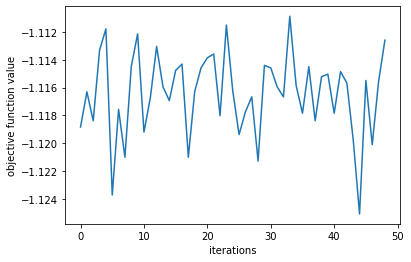

In [9]:
n_shots=1000

def GIVE_ENERGY(theta_ia_theta_jab_list):
    theta_ia = theta_ia_theta_jab_list[:len(theta_parameters_ia)]
    theta_ijab = theta_ia_theta_jab_list[len(theta_parameters_ia):]
    
    ansatz_cirq_circuit = full_ansatz_Q_Circ.Get_Full_HF_UCCSD_QC(theta_parameters_ia, theta_parameters_ijab)

    VQE_exp = VQE_Experiment(QubitHam, ansatz_cirq_circuit, n_shots)
    

    return VQE_exp.Calc_Energy()

### optimizer
from quchem.Scipy_Optimizer import *
# THETA_params = [*theta_parameters_ia, *theta_parameters_ijab]
THETA_params=[0,0,0]
GG = Optimizer(GIVE_ENERGY, THETA_params, 'Nelder-Mead', store_values=True, display_iter_steps=True,
               tol=1e-5,
               display_convergence_message=True)
GG.get_env(50)
GG.plot_convergence()
plt.show()

## REDUCED H2 ansatz:

In [10]:
from quchem.Simulating_Quantum_Circuit import *
from quchem.Ansatz_Generator_Functions import *
from openfermion.ops import QubitOperator

def H2_ansatz(theta):
    HF_circ = [cirq.X.on(cirq.LineQubit(0)), cirq.X.on(cirq.LineQubit(1))]
    
    full_exp_circ_obj = full_exponentiated_PauliWord_circuit(QubitOperator('Y0 X1 X2 X3', -1j), theta)
    UCCSD_circ = cirq.Circuit(cirq.decompose_once((full_exp_circ_obj(*cirq.LineQubit.range(full_exp_circ_obj.num_qubits())))))
    full_circuit = cirq.Circuit([*HF_circ, *UCCSD_circ.all_operations()])
    
    return full_circuit
    
H2_ansatz(np.pi)               

0: ───X───Rx(0.5π)───@──────────────────────────────@───Rx(-0.5π)───
                     │                              │
1: ───X───H──────────X───@──────────────────────@───X───H───────────
                         │                      │
2: ───H──────────────────X───@──────────────@───X───H───────────────
                             │              │
3: ───H──────────────────────X───Rz(2.0π)───X───H───────────────────

In [11]:
n_shots=1000

def GIVE_ENERGY(THETA):
   
    ansatz_cirq_circuit = H2_ansatz(THETA)

    VQE_exp = VQE_Experiment(QubitHam, ansatz_cirq_circuit, n_shots)

    return VQE_exp.Calc_Energy()


-1.1373435841146557


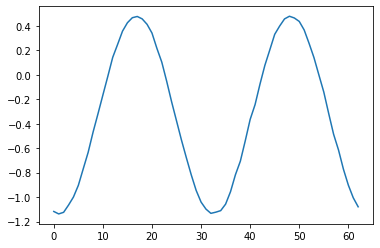

In [12]:
### full angle scan

import matplotlib.pyplot as plt
%matplotlib inline

theta_list = np.arange(0,2*np.pi, 0.1)

E_list = [GIVE_ENERGY(theta) for theta in theta_list]

plt.plot(E_list)
print(min(E_list))

0: Input_to_Funct: [2.3]: Output: -0.058458098910411926
1: Input_to_Funct: [2.7]: Output: -0.694898287710437
2: Input_to_Funct: [3.1]: Output: -1.1000942099698485
3: Input_to_Funct: [3.3]: Output: -1.1330803222454058
4: Input_to_Funct: [3.2]: Output: -1.1337591613565454
5: Input_to_Funct: [3.2]: Output: -1.1301545473871317
6: Input_to_Funct: [3.225]: Output: -1.1345419890439155
7: Input_to_Funct: [3.225]: Output: -1.1404383941335479
8: Input_to_Funct: [3.225]: Output: -1.128671036255271
9: Input_to_Funct: [3.225]: Output: -1.1382749867085218
10: Input_to_Funct: [3.225]: Output: -1.1339395718439667
11: Input_to_Funct: [3.225]: Output: -1.1361616630655416
12: Input_to_Funct: [3.225]: Output: -1.1390548673765042
13: Input_to_Funct: [3.225]: Output: -1.13499106417041
14: Input_to_Funct: [3.225]: Output: -1.1356301538080331
15: Input_to_Funct: [3.225]: Output: -1.138522252092495
16: Input_to_Funct: [3.225]: Output: -1.1313059590801648
17: Input_to_Funct: [3.225]: Output: -1.1386437747487763

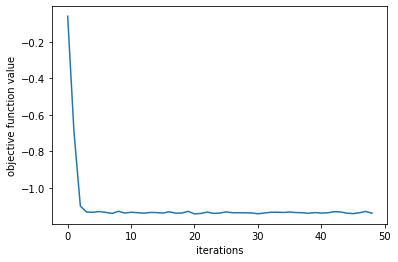

In [13]:
## optimzer

from quchem.Scipy_Optimizer import *
THETA_params=[2]
GG = Optimizer(GIVE_ENERGY, THETA_params, 'Nelder-Mead', store_values=True, display_iter_steps=True,
               tol=1e-5,
               display_convergence_message=True)
GG.get_env(50)
GG.plot_convergence()
plt.show()

In [14]:
ansatz_cirq_circuit = H2_ansatz(3.22500077)
VQE_exp = VQE_Experiment(QubitHam, ansatz_cirq_circuit, 1000)
print('Energy = ', VQE_exp.Calc_Energy())
print('')
print('state:')
VQE_exp.Get_wavefunction_of_state(sig_figs=4)

Energy =  -1.1349360253505665

state:


array([[ 0.    +0.j],
       [ 0.    +0.j],
       [ 0.    +0.j],
       [ 0.0833-0.j],
       [-0.    +0.j],
       [-0.    +0.j],
       [-0.    +0.j],
       [-0.    +0.j],
       [ 0.    +0.j],
       [ 0.    +0.j],
       [ 0.    +0.j],
       [ 0.    +0.j],
       [-0.9965+0.j],
       [-0.    +0.j],
       [-0.    +0.j],
       [-0.    +0.j]], dtype=complex64)